<a href="https://colab.research.google.com/github/mkirby1995/DS-Unit-2-Sprint-2-Regression/blob/master/LS_DS_411A_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Tree Ensembles_ 

# Decision Trees Assignment

## Part 1: House Price Regression

Apply decision trees to the Ames housing dataset you've worked with this week!

- Try multiple features
- Try features you've engineered
- Try different `max_depth` paramaters
- What's the best Test Root Mean Squared Error you can get? *Share with your cohort on Slack!*
- What's a cool visualization you can make? *Share with your cohort on Slack!*

###Import Data

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np 
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
rcParams['figure.figsize'] = 19, 10
import graphviz
from IPython.display import display
from ipywidgets import interact
from mpl_toolkits import mplot3d
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz


def viztree(decision_tree, feature_names):
    """Visualize a decision tree"""
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)

In [0]:
Ames = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv'

df = pd.read_csv(Ames)

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000




---



###Clean Data

In [0]:
df['MSZoning'] = df['MSZoning'].replace({'RL':5,'FV':4,'RM':3,'RH':2,'C (all)':1})

df['Street'] = df['Street'].replace({'Grvl':0, 'Pave':1})

df['LotShape'] = df['LotShape'].replace({'Reg':4,'IR1':3,'IR2':2,'IR3':1})
df['LotShape'] = df['LotShape'].astype('int64')

df['LandContour'] = df['LandContour'].replace({'Lvl':4, 'Bnk':2, 'HLS':3, 'Low':1})

df['Utilities'] = df['Utilities'].replace({'AllPub':1, 'NoSeWa':0})

df['LotConfig'] = df['LotConfig'].replace({'CulDSac':5, 'FR3':4, 'Corner':3, 'FR2':2, 'Inside':1})

df['LandSlope'] = df['LandSlope'].replace({'Sev':3, 'Mod':2, 'Gtl':1})

df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

df['Alley'] = df['Alley'].replace({'Grvl':1, 'Pave':2, np.NaN:3})

df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

df['YearBuilt ** 2'] = df['YearBuilt'] ** 2


df['HouseStyle'] = df['HouseStyle'].replace({'1.5Fin':3, '1.5Unf':1, '1Story':6,
                                             '2.5Fin':8, '2.5Unf':4, '2Story':7,
                                             'SFoyer':2,'SLvl':5})

df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())



---



### Engineer Features

In [0]:
mean_price_nei = pd.pivot_table(data = df, values='SalePrice', index='Neighborhood', columns=None, aggfunc='median')

sorted_means = mean_price_nei.sort_values(by='SalePrice', ascending=False)

neighborhood_names = []
neighborhood_scores =[]

for _ in range(len(sorted_means)):
  #print(sorted_means.index[_], sorted_means['SalePrice'][_])
  neighborhood_names.append(sorted_means.index[_])
  
for _ in range(len(neighborhood_names)):
  neighborhood_scores.append(25 - _)
  
neighborhoodz = dict(zip(neighborhood_names, neighborhood_scores))

df['neighborhood_score'] = df['Neighborhood'].replace(neighborhoodz)

In [0]:
df['ln_price'] = np.log(df['SalePrice'])

In [0]:
df['ExterQual'] = df['ExterQual'].replace({'Ex':5, 'Gd':4, 'TA':3,
                                           'Fa':2, 'Po':1})

df['ExterCond'] = df['ExterCond'].replace({'Ex':5, 'Gd':4, 'TA':3,
                                           'Fa':2, 'Po':1})

df['HeatingQC'] = df['HeatingQC'].replace({'Ex':5, 'Gd':4, 'TA':3,
                                           'Fa':2, 'Po':1})

df['KitchenQual'] = df['KitchenQual'].replace({'Ex':5, 'Gd':4, 'TA':3,
                                               'Fa':2, 'Po':1})

df['KitchenQual'] = df['KitchenQual'].astype('int64')

df['GarageQual'] = df['GarageQual'].replace({'Ex':5, 'Gd':4, 'TA':3,
                                             'Fa':2, 'Po':1, 'NA': 0,})

df['GarageQual'] = df['GarageQual'].fillna(0)

df['GarageQual'] = df['GarageQual'].astype('int64')

df['GarageCond'] = df['GarageCond'].replace({'Ex':5, 'Gd':4, 'TA':3,
                                             'Fa':2, 'Po':1, 'NA': 0})

df['GarageCond'] = df['GarageCond'].fillna(0)

df['GarageCond'] = df['GarageCond'].astype('int64')

df['BsmtCond'] = df['BsmtCond'].replace({'Ex':5, 'Gd':4, 'TA':3,
                                         'Fa':2, 'Po':1, 'NA': 0})

df['BsmtCond'] = df['BsmtCond'].fillna(0)

Prop_cols = [df['OverallQual'], df['OverallCond'], df['ExterQual'],
             df['ExterCond'], df['KitchenQual'], df['HeatingQC'],
             df['GarageQual'], df['GarageCond'], df['BsmtCond']]

df['property_score'] = sum(Prop_cols)

df['property_score'] = df['property_score'].astype('int64')



---



###Functions

####Remove Outliers

In [0]:

def remove_outliers(col_name, std_threshold):
  """
  Given a column name (df['column_name']) and a standard deviation threshold
  multiplier (int or float) this function will return a new column with
  outliers replaced by the column mean
  """
  
  std = col_name.std()
  thresh = std_threshold
  mean = col_name.mean()
  values = []

  for _ in range(len(col_name)):
    value = col_name[_]
  
    if value > (mean + std*thresh):
      value = mean
    
    elif value < (mean - std*thresh):
      value = mean
    
    values.append(value)
    
  new_col = pd.Series(values)
  
  return new_col



---



####Create Decision Tree

In [0]:
def decision_tree(target, feature, max_depth):
  """
  Given a target and feature column names (df['target_name'],
  df[[feature_name]]) and a mex tree depth (int) this function will fit
  a decision tree and display a visual representation.
  """
  x = feature
  y = target
  
  # Train test split
  xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = .2)
  #print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)
  
  # Set and fit model
  tree = DecisionTreeRegressor(max_depth=max_depth)
  tree.fit(x, y)

  # R^2
  test_score = tree.score(xtest, ytest)
  train_score = tree.score(xtrain, ytrain)
  print('Test R-Squared Value\n', test_score)
  print('Train R-Squared Value\n', train_score)

  # Plot results
  plt.scatter(x, y)
  ax = plt.gca()
  ax.step(x, tree.predict(x), where='mid')
  plt.show();
  display(viztree(tree, feature_names=[feature.columns[0]]))

  plt.show();



---



####Bivirate Linear Regression

In [0]:
def bv_model(target, feature_):
  """
  Given a feature column name and a target column name this function will fit a 
  bivirate model and display a plot.
  """
  # Set feature and target
  target = df[target]
  feature = np.array(df[feature_]).reshape(-1, 1)
  
  # Train test split
  xtrain, xtest, ytrain, ytest = train_test_split(feature, target, test_size = .2)
  #print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)
  
  # Set and fit model
  linreg = LinearRegression()
  linreg.fit(feature, target)

  # Intercept and Coefficient
  #beta_0 = linreg.intercept_
  #beta_i = linreg.coef_
  #print("Slope Coefficients: ", beta_i)
  #print("\nIntercept Value: ", beta_0)
  
  # RMSE and r^2
  print('Root Mean Squared Error\n', np.sqrt(mean_squared_error(target, linreg.predict(feature))))
  print('R-Squared Value\n', linreg.score(feature, target))
  
  # Create new series with predictions
  Bivariate_Prediction = pd.Series(linreg.predict(feature))

  # Plot results
  plt.scatter(df[feature_], target, c=target, cmap='cool')
  plt.plot(df[feature_], Bivariate_Prediction, c='black')
  plt.ylabel('target')
  plt.xlabel('feature')

  plt.show();



---



###Create Feature List

In [0]:
non_obj = []
for _ in range(len(df.dtypes)):
  if df.dtypes[_] != object:
    #print(df.dtypes.index[_], df.dtypes[_])
    non_obj.append(df.dtypes.index[_])

In [12]:
feature_list = df[non_obj]
feature_list = feature_list.drop(columns = ['Id', 'SalePrice', 'ln_price', 'MoSold', 'MSSubClass'])
feature_list.columns

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'ExterCond', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'YearBuilt ** 2',
       'neighborhood_score', 'property_score'],
      dtype='object')

In [0]:
features = feature_list.columns.tolist()



---



### Plot

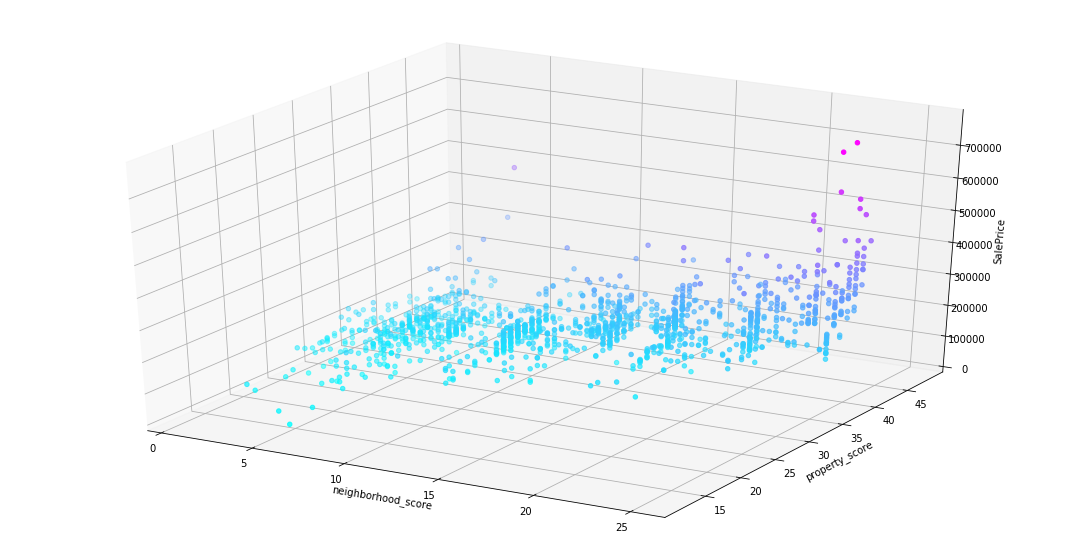

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot Points on 3D plot
ax.scatter(df['neighborhood_score'], df['property_score'], df['SalePrice'], c=df['SalePrice'], cmap='cool')

ax.set_zlabel('SalePrice');
plt.xlabel('neighborhood_score')
plt.ylabel('property_score')

#ax.set_xlim(1900,2015)
#ax.set_ylim(200,14000)
#ax.set_zlim(75000,8000000)

plt.show();

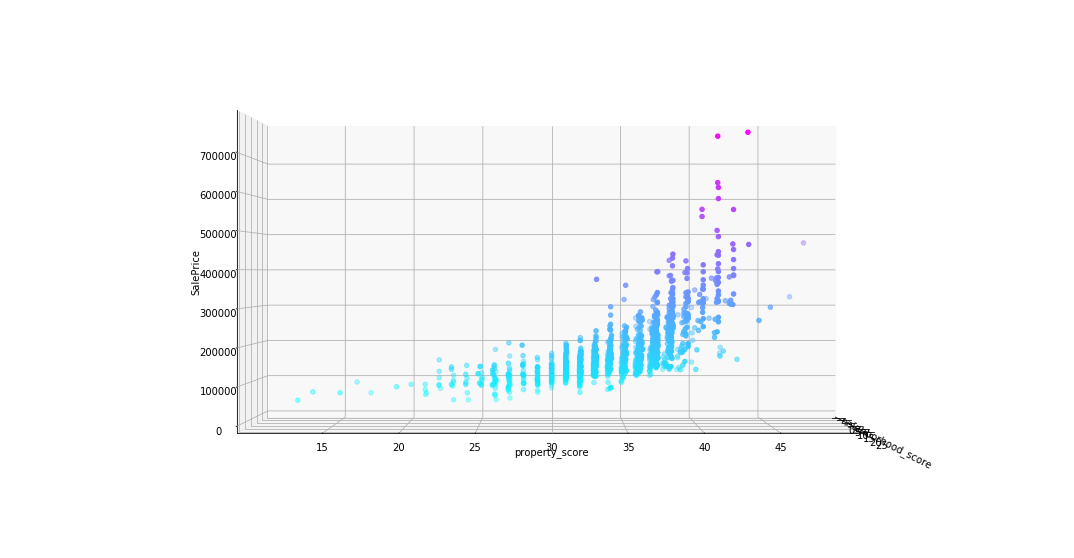

In [15]:
ax.view_init(0, 0)
fig

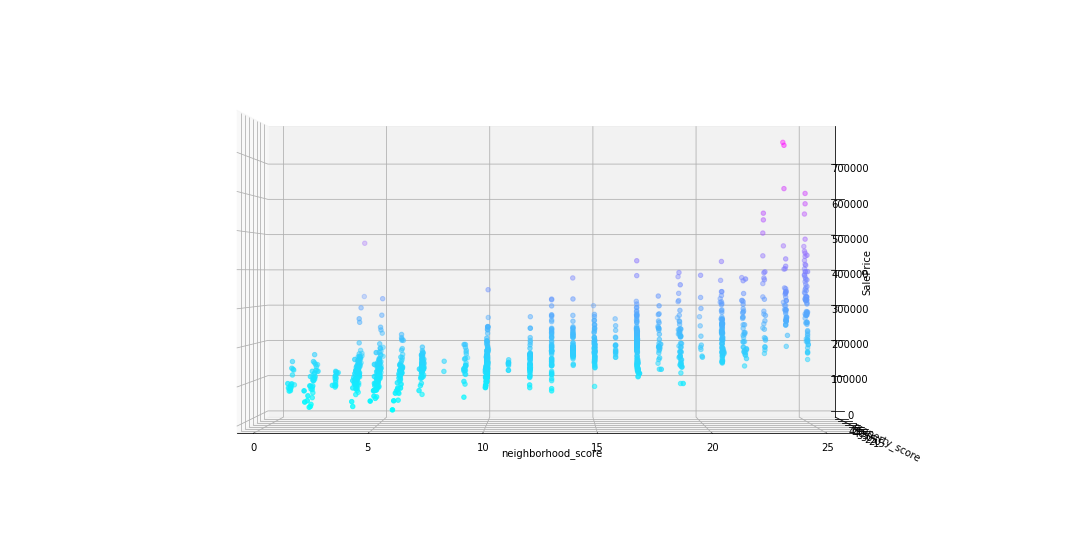

In [16]:
ax.view_init(0, -90)
fig

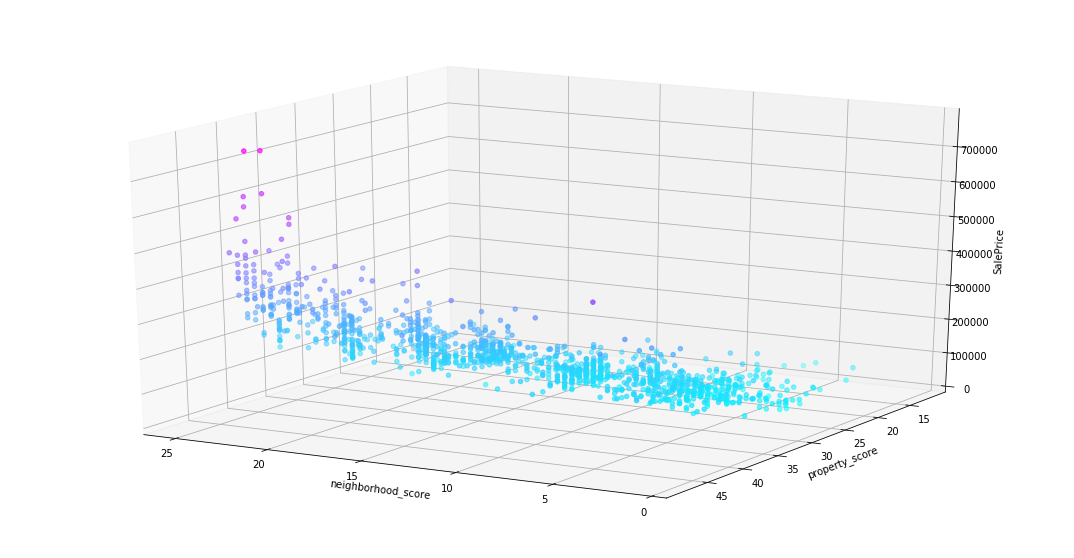

In [17]:
ax.view_init(20, 120)
fig

###Decision Tree

In [0]:
#features

In [0]:
feature = 'LotArea'
target = 'SalePrice'

df = df.sort_values(by = feature)
decision_tree(df[target], df[[feature]], 15)

In [0]:
feature = 'neighborhood_score'
target = 'SalePrice'

df = df.sort_values(by = feature)
decision_tree(df[target], df[[feature]], 5)

Test R-Squared Value
 0.601574339408202
Train R-Squared Value
 0.594487151551234


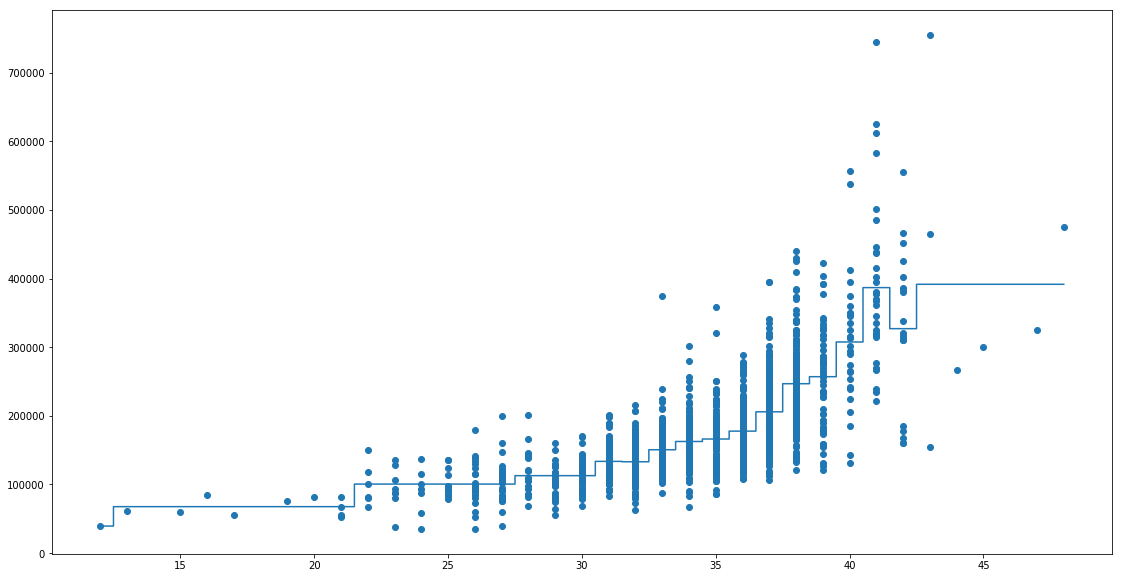

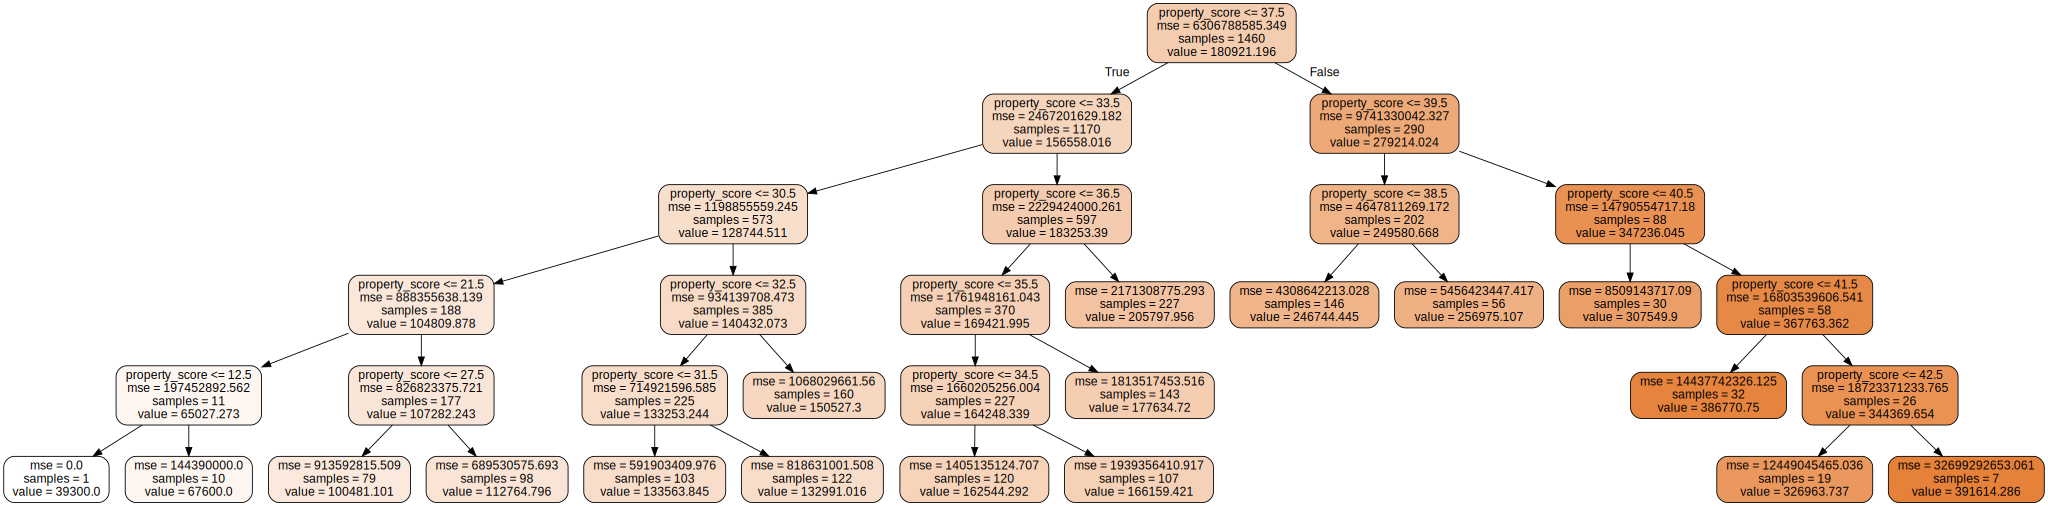

In [24]:
feature = 'property_score'
target = 'SalePrice'

df = df.sort_values(by = feature)
decision_tree(df[target], df[[feature]], 5)

In [48]:
for _ in range(len(features)):
  x = df[[features[_]]]
  y = df['SalePrice']
  
  # Set and fit model
  tree = DecisionTreeRegressor(max_depth=100)
  tree.fit(x, y)

  # RMSE and r^2
  score = tree.score(x, y)
  #print('R-Squared Value\n', score)
  if score > .5:
    print(features[_], score)

LotArea 0.9191641458940722
OverallQual 0.6841812868534439
BsmtFinSF1 0.6296236653319345
BsmtUnfSF 0.6340645690914163
TotalBsmtSF 0.8194590998300435
1stFlrSF 0.7862271343770332
GrLivArea 0.8835703492273516
GarageArea 0.7698957300521989
neighborhood_score 0.5455749908095633
property_score 0.6019911240442826




---



## Part 2 / Stretch: "Play Tennis" Classification

We'll reproduce the "Play Tennis" example from Ross Quinlan's 1986 paper, [Induction of Decison Trees](https://link.springer.com/content/pdf/10.1007%2FBF00116251.pdf).

[According to Wikipedia](https://en.wikipedia.org/wiki/Ross_Quinlan), "John Ross Quinlan is a computer science researcher in data mining and decision theory. He has contributed extensively to the development of decision tree algorithms, including inventing the canonical C4.5 and ID3 algorithms."

#### "Table 1 shows a small training set"

In [51]:
import pandas as pd

columns = 'No. Outlook Temperature Humidity Windy PlayTennis'.split()

raw = """1 sunny hot high false N
2 sunny hot high true N
3 overcast hot high false P
4 rain mild high false P
5 rain cool normal false P
6 rain cool normal true N
7 overcast cool normal true P
8 sunny mild high false N
9 sunny cool normal false P
10 rain mild normal false P
11 sunny mild normal true P
12 overcast mild high true P
13 overcast hot normal false P
14 rain mild high true N"""

data = [row.split() for row in raw.split('\n')]
tennis = pd.DataFrame(data=data, columns=columns).set_index('No.')
tennis['PlayTennis'] = (tennis['PlayTennis'] == 'P').astype(int)

tennis

,Outlook,Temperature,Humidity,Windy,PlayTennis
No.,,,,,
1,sunny,hot,high,false,0
2,sunny,hot,high,true,0
3,overcast,hot,high,false,1
4,rain,mild,high,false,1
5,rain,cool,normal,false,1
6,rain,cool,normal,true,0
7,overcast,cool,normal,true,1
8,sunny,mild,high,false,0
9,sunny,cool,normal,false,1


#### "A decision tree that correctly classifies each object in the training set is given in Figure 2."

<img src="https://i.imgur.com/RD7d0u0.png" height="300">

In this dataset, the tennis player decided to play on 64% of the days, and decided not to on 36% of the days.

In [52]:
tennis['PlayTennis'].value_counts(normalize=True) * 100

1    64.285714
0    35.714286
Name: PlayTennis, dtype: float64

The tennis player played on 100% of the overcast days, 40% of the sunny days, and 60% of the  rainy days

In [53]:
tennis.groupby('Outlook')['PlayTennis'].mean() * 100

Outlook
overcast    100.0
rain         60.0
sunny        40.0
Name: PlayTennis, dtype: float64

On sunny days, the tennis player's decision depends on the humidity. (The Outlook and Humidity features interact.)

In [14]:
sunny = tennis[tennis['Outlook']=='sunny']
sunny.groupby('Humidity')['PlayTennis'].mean() * 100

Humidity
high        0
normal    100
Name: PlayTennis, dtype: int64

On rainy days, the tennis player's decision depends on the wind. (The Outlook and Windy features interact.)

In [15]:
rainy = tennis[tennis['Outlook']=='rain']
rainy.groupby('Windy')['PlayTennis'].mean() * 100

Windy
false    100
true       0
Name: PlayTennis, dtype: int64

#### Before modeling, we will ["encode" categorical variables, using pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html?highlight=get_dummies#computing-indicator-dummy-variables)

In [66]:
y = tennis['PlayTennis']
X = pd.get_dummies(tennis.drop(columns='PlayTennis'))
X

,Outlook_overcast,Outlook_rain,Outlook_sunny,Temperature_cool,Temperature_hot,Temperature_mild,Humidity_high,Humidity_normal,Windy_false,Windy_true
No.,,,,,,,,,,
1,0,0,1,0,1,0,1,0,1,0
2,0,0,1,0,1,0,1,0,0,1
3,1,0,0,0,1,0,1,0,1,0
4,0,1,0,0,0,1,1,0,1,0
5,0,1,0,1,0,0,0,1,1,0
6,0,1,0,1,0,0,0,1,0,1
7,1,0,0,1,0,0,0,1,0,1
8,0,0,1,0,0,1,1,0,1,0
9,0,0,1,1,0,0,0,1,1,0


## Train a Decision Tree Classifier
Get a score of 100% (accuracy)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [58]:
y = tennis['PlayTennis']
x = pd.get_dummies(tennis.drop(columns='PlayTennis'))

# Train test split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = .2)
#print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

# Set and fit model
DTC = DecisionTreeClassifier(max_depth=4)
DTC.fit(x, y)

# R^2
test_score = DTC.score(xtest, ytest)
train_score = DTC.score(xtrain, ytrain)
print('Test R-Squared Value\n', test_score)
print('Train R-Squared Value\n', train_score)

Test R-Squared Value
 1.0
Train R-Squared Value
 1.0


## Compare to Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [63]:
y = tennis['PlayTennis']
x = pd.get_dummies(tennis.drop(columns='PlayTennis'))

# Train test split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = .2)
#print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

# Set and fit model
logreg = LogisticRegression(solver='liblinear')
logreg.fit(x, y)

# R^2
test_score = logreg.score(xtest, ytest)
train_score = logreg.score(xtrain, ytrain)
print('Test R-Squared Value\n', test_score)
print('Train R-Squared Value\n', train_score)

Test R-Squared Value
 0.6666666666666666
Train R-Squared Value
 0.9090909090909091


## Visualize the tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

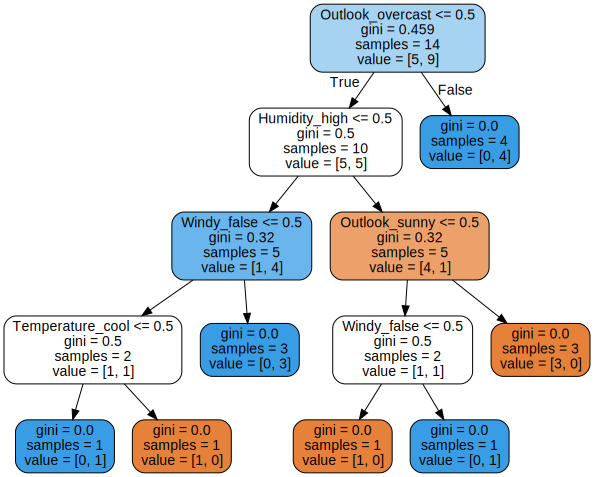

In [68]:
display(viztree(DTC, feature_names=X.columns))